# <span style="font-weight: bolder;">Spatial Clustering Demonstration of 12 Slices from the DLPFC Dataset(10xVisium)</span>
We demonstrate how to use 3d-OT to obtain the clustering results of 12 spatial slices from the DLPFC

## <span style="font-weight: bolder;">Loading package</span>

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.single_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## <span style="font-weight: bolder;">Loading and Pre-processing 151674 slice data</span>
We use SCANPY package to select Top3000 HVGs and perform standard data processing,The standard processed expression matrix `adata.X` is used as input

In [3]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151674/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151674_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

## <span style="font-weight: bolder;">Ground truth of 151674 slice</span>

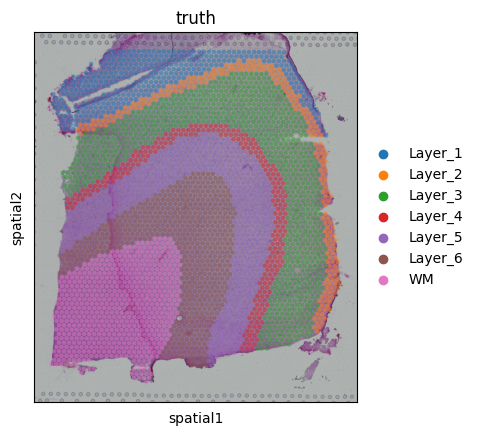

In [4]:
sc.pl.spatial(adata, img_key="hires", color="truth", alpha=0.5, size=1.3)

## <span style="font-weight: bolder;"> Constructing neighbor graph and training Pointnet++Encoder</span>

In [5]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.727270, Min Loss: 0.727269

### Obtain the reconstruction matrix `decoded_features`

In [6]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

## Clustering with mclust ,Clustering results can be found in `adata.obs['3d-OT']`

In [ ]:
clustering(adata, n_clusters=7, radius=50, key='3d-OT', method='mclust', refinement=True,random=14,n_comp=40)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


## <span style="font-weight: bolder;"> 151674 clustering results</span>

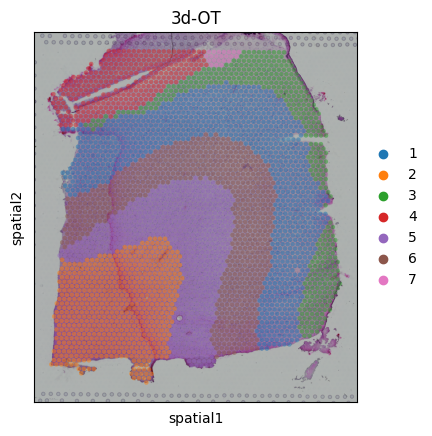

In [8]:
sc.pl.spatial(adata, color='3d-OT', img_key='hires', alpha=0.5, size=1.3)

## <span style="font-weight: bolder;"> Quantitative evaluation of clustering performance</span>

In [9]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.722191434362515, 0.7656380326054507)

## <span style="font-weight: bolder;"> 151673 slice</span>

In [10]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151673/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151673_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

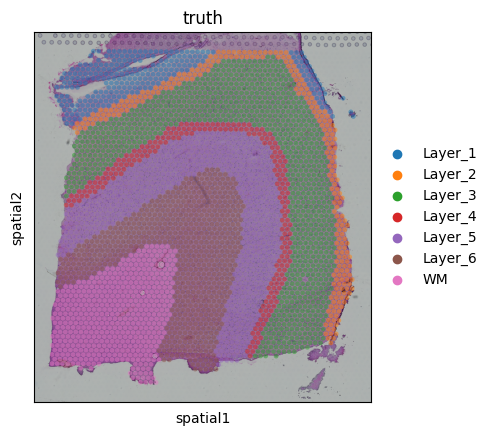

In [11]:
sc.pl.spatial(adata, img_key="hires", color="truth", alpha=0.5, size=1.3)

In [12]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.718978, Min Loss: 0.718896

In [13]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [14]:
clustering(adata, n_clusters=7, radius=50, key='3d-OT', method='mclust', refinement=True,random=9,n_comp=30)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


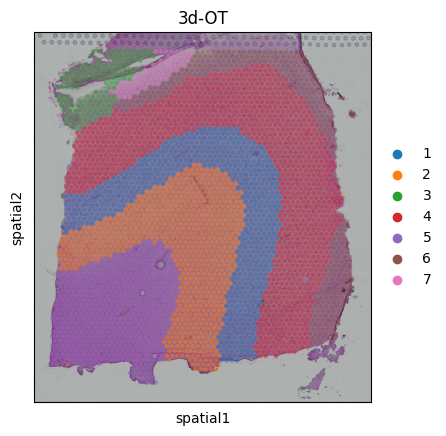

In [15]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [16]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.7028480564311802, 0.7433446134677156)

## <span style="font-weight: bolder;">151675 slice</span>

In [17]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151675/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151675_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

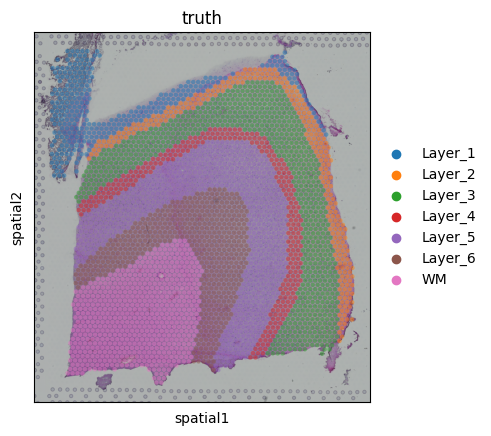

In [18]:
sc.pl.spatial(adata, img_key="hires", color="truth", alpha=0.5, size=1.3)

In [19]:
set_seed(15)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.714007, Min Loss: 0.714108

In [21]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [22]:
clustering(adata, n_clusters=7, radius=45, key='3d-OT', method='mclust', refinement=True,random=31,n_comp=40)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


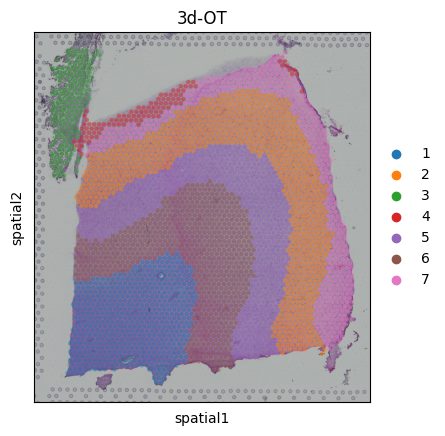

In [23]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [24]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6459690560890312, 0.7278819998330281)

## <span style="font-weight: bolder;">151676 slice</span>

In [25]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151676/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151676_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [26]:
set_seed(15)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.718553, Min Loss: 0.718643

In [27]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [29]:
clustering(adata, n_clusters=7, radius=50, key='3d-OT', method='mclust', refinement=True,random=24,n_comp=30)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


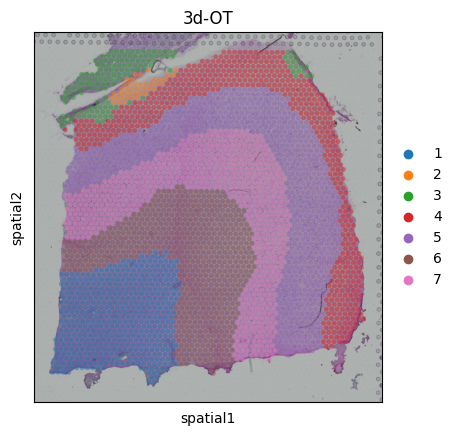

In [30]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [31]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6310955240816976, 0.7131788712754157)

## <span style="font-weight: bolder;">151507 slice</span>

In [32]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151507/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151507_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [33]:
set_seed(32)
graph = prepare_data(adata, location="spatial", nb_neighbors=10).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1500)

Epoch 1500/1500, Loss: 0.695670, Min Loss: 0.695676

In [34]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [36]:
clustering(adata, n_clusters=7, radius=70, key='3d-OT', method='mclust', refinement=True,random=47,n_comp=40)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


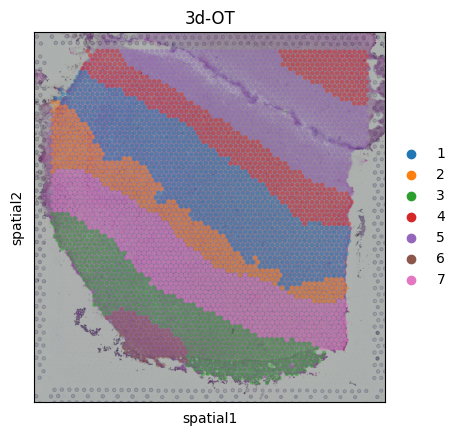

In [37]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [38]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6429481541625701, 0.724894657369434)

## <span style="font-weight: bolder;">151508 slice</span>

In [39]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151508/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151508_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [40]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=18).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.697022, Min Loss: 0.697038

In [41]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [42]:
clustering(adata, n_clusters=7, radius=150, key='3d-OT', method='mclust', refinement=True,random=7,n_comp=30)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


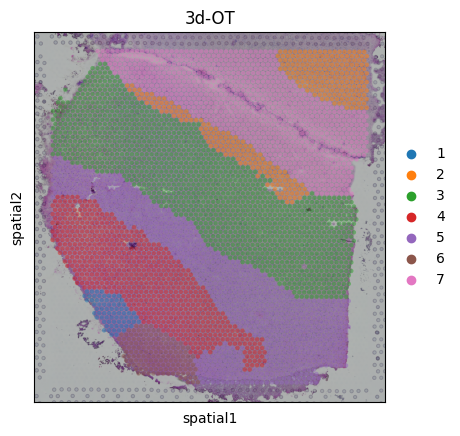

In [43]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [44]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.63927519123311, 0.6763409724698999)

## <span style="font-weight: bolder;">151509 slice</span>

In [45]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151509/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151509_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [46]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=20).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.709234, Min Loss: 0.708868

In [47]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [48]:
clustering(adata, n_clusters=7, radius=20, key='3d-OT', method='mclust', refinement=True,random=42,n_comp=40)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


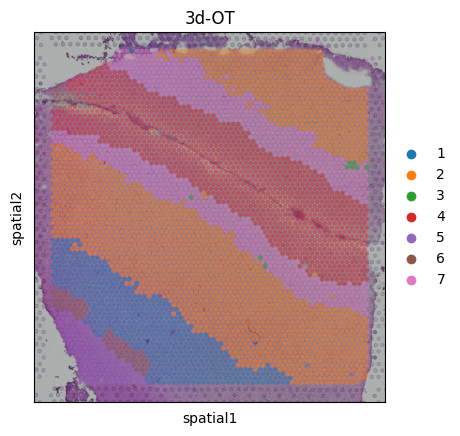

In [49]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [50]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6850812804724349, 0.7180048814116741)

## <span style="font-weight: bolder;">151510 slice</span>

In [51]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151510/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151510_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [52]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.693114, Min Loss: 0.693208

In [53]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [54]:
clustering(adata, n_clusters=7, radius=50, key='3d-OT', method='mclust', refinement=True,random=2,n_comp=30)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


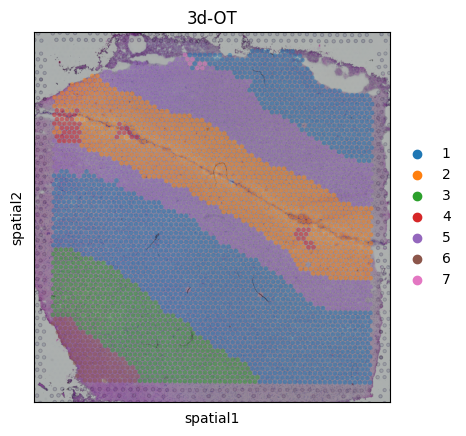

In [55]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [56]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6219086058402626, 0.6800061169876953)

## <span style="font-weight: bolder;">151669 slice</span>

In [3]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151669/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151669_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [4]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.714648, Min Loss: 0.714807

In [5]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [6]:
clustering(adata, n_clusters=5, radius=50, key='3d-OT', method='mclust', refinement=True,random=6,n_comp=40)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


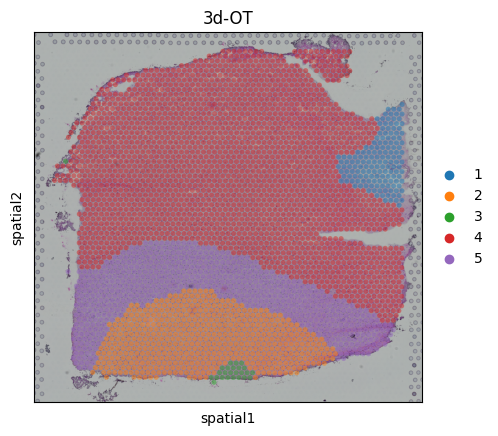

In [7]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [8]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6835502280197584, 0.6791096322579064)

## <span style="font-weight: bolder;">151670 slice</span>

In [9]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151670/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151670_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [10]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.717278, Min Loss: 0.717233

In [11]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [12]:
clustering(adata, n_clusters=5, radius=50, key='3d-OT', method='mclust', refinement=True,random=9,n_comp=40)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


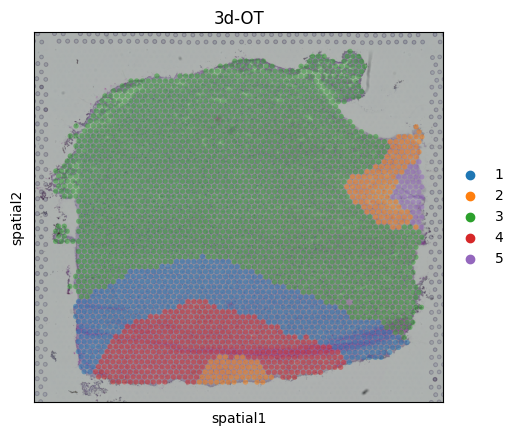

In [13]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [14]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6332187919483075, 0.6069832150365367)

## <span style="font-weight: bolder;">151671 slice</span>

In [15]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151671/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151671_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [16]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=36).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.705453, Min Loss: 0.705474

In [17]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [18]:
clustering(adata, n_clusters=5, radius=110, key='3d-OT', method='mclust', refinement=True,random=5,n_comp=40)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


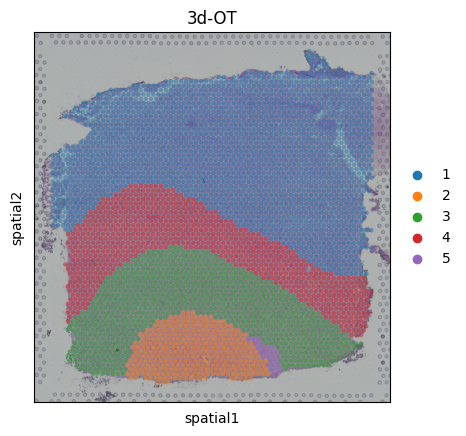

In [19]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [20]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.8486307773696931, 0.804415974551904)

## <span style="font-weight: bolder;">151672 slice</span>

In [21]:
adata=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151672/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151672_truth.csv', sep='\t', index_col=0)
adata.obs['truth'] = truth.iloc[:,0]
adata = adata[~adata.obs['truth'].isna(), :]
adata.obsm['feat']=adata.X

In [22]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.711288, Min Loss: 0.711311

In [23]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

In [24]:
clustering(adata, n_clusters=5, radius=110, key='3d-OT', method='mclust', refinement=True,random=3,n_comp=50)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


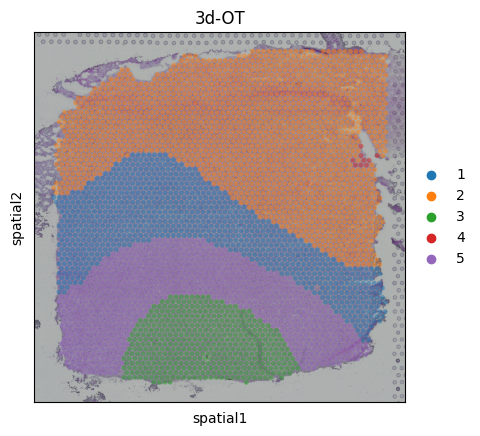

In [25]:
sc.pl.spatial(adata, img_key="hires", color="3d-OT", alpha=0.5, size=1.3)

In [26]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.7979786569154225, 0.7719936179336607)